In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import confusion_matrix, f1_score, RocCurveDisplay

from catboost import CatBoostClassifier, Pool
import optuna
from IPython.display import display

In [3]:
# Load the dataset
df = pd.read_csv(r"D:\tesis_u_sabana\data\results\contracts_colombia__analysis.csv", sep="~", encoding='utf-8')
df.drop(columns=[
    'id_contrato', 'documento_proveedor','nit_entidad_x','va_2022_a1', 'fecha_de_inicio_del_contrato',
    'fecha_de_fin_del_contrato','va_2022_a2', 'va_2022_a3', 'va_2022', 'va_%_d_2022','valor_facturado',
    'valor_pendiente_de_pago','valor_de_pago_adelantado','valor_pendiente_de_ejecucion','codigo_proveedor',
    'id_del_proceso', 'id_del_portafolio','dominant_topic_y','valor_del_contrato_y','codigo','departamento_y', 'latitud',
    'longitud', 'codigo_capital', 'capital','estado_contrato'
], inplace=True)
df.drop(df.index[0], inplace=True)
scaler = MinMaxScaler()
df[['poblacion_m']] = scaler.fit_transform(df[['poblacion_m']])
df[['%_nbi']] = scaler.fit_transform(df[['%_nbi']])
df[['d_a_capital']] = scaler.fit_transform(df[['d_a_capital']])

In [4]:

# Prepare X and y
y = df['tipo_de_modificacion']
X = df.drop(columns=['tipo_de_modificacion'])
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
X = X.copy()
X[categorical_features] = X[categorical_features].fillna("missing").astype('category')
X["dominant_topic_x"] = X["dominant_topic_x"].astype("category")
categorical_features.append("dominant_topic_x")


In [5]:
# MCCV evaluation function
def mccv_evaluation(learner, X, y, repeats=10, train_size=0.7, pipeline_name=None, categorical_features=None):
    print("Performing Monte Carlo Cross Validation for Evaluation")
    print(f"Repeats: {repeats}")
    label_order = np.unique(y)
    conf_matrix_sum = None
    f_score_sum = 0.000001
    all_y_true = []
    all_y_prob = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'MCCV Evaluation - {pipeline_name}')
    color_map = {
        "sin_cambios": "green",
        "modificacion_riesgosa": "red",
        "modificacion_general": "gold"
    }
    for i in range(repeats):
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, stratify=y, random_state=i)
        learner.fit(X_train, y_train, cat_features=categorical_features)
        y_pred = learner.predict(X_val)
        cm = confusion_matrix(y_val, y_pred, labels=label_order)
        conf_matrix_sum = cm if conf_matrix_sum is None else conf_matrix_sum + cm
        f_score = f1_score(y_val, y_pred, average="weighted", labels=label_order)
        f_score_sum += f_score
        print(f"Iteration {i+1}/{repeats} - F1 Score: {f_score:.4f}")
        try:
            y_prob = learner.predict_proba(X_val)
            all_y_true.extend(y_val)
            all_y_prob.extend(y_prob)
        except AttributeError:
            print("Warning: predict_proba not available.")
    print(f"Average F1 Score: {f_score_sum / repeats:.4f}")
    avg_conf_matrix = conf_matrix_sum / repeats
    avg_confusion_df = pd.DataFrame(avg_conf_matrix, index=label_order, columns=label_order)
    sns.heatmap(avg_confusion_df, annot=True, cmap="Blues", fmt=".2f", cbar=True, ax=ax1)
    ax1.set_title("Average Confusion Matrix")
    try:
        all_y_true_bin = label_binarize(all_y_true, classes=label_order)
        all_y_prob = np.array(all_y_prob)
        for j, class_label in enumerate(label_order):
            RocCurveDisplay.from_predictions(all_y_true_bin[:, j], all_y_prob[:, j], ax=ax2, name=f"Class {class_label}", color=color_map.get(class_label, "gray"))
    except Exception as e:
        print(f"Could not plot ROC: {e}")
    ax2.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    ax2.set_title('Multi-class ROC Curve')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return avg_confusion_df


In [6]:
def objective(trial):
    # fresh copy of X
    X_opt = X.copy()
    
    # detect all categorical columns
    cat_cols = X_opt.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # ensure it’s a CategoricalDtype
        if not pd.api.types.is_categorical_dtype(X_opt[col]):
            X_opt[col] = X_opt[col].astype('category')
        # add "missing" only if not already present
        if 'missing' not in X_opt[col].cat.categories:
            X_opt[col] = X_opt[col].cat.add_categories('missing')
        # now safe to fill
        X_opt[col] = X_opt[col].fillna('missing')
    
    # sample hyperparameters
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
    param = {
        "iterations": trial.suggest_int("iterations", 300, 1200),
        "depth": trial.suggest_int("depth", 6, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 10),
        "random_strength": trial.suggest_float("random_strength", 1, 20),
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128]),
        "bootstrap_type": bootstrap_type,
        "random_seed": 7,
        "task_type": "GPU",
        "verbose": 0
    }
    if bootstrap_type == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.5, 2.0)
    else:
        param["subsample"] = trial.suggest_float("subsample", 0.7, 1.0)
    
    model = CatBoostClassifier(**param)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    scores = cross_val_score(
        model,
        X_opt,
        y,
        cv=cv,
        scoring="f1_weighted",
        fit_params={"cat_features": cat_cols}
    )
    return scores.mean()


In [7]:
# Optuna objective with fixes for GPU multiclass compatibility
def objective(trial):
    # Copy and safely fill categoricals
    X_opt = X.copy()
    cat_cols = X_opt.select_dtypes(include=['object','category']).columns.tolist()
    for col in cat_cols:
        if not pd.api.types.is_categorical_dtype(X_opt[col]):
            X_opt[col] = X_opt[col].astype('category')
        if 'missing' not in X_opt[col].cat.categories:
            X_opt[col] = X_opt[col].cat.add_categories('missing')
        X_opt[col] = X_opt[col].fillna('missing')

    # Hyperparameter sampling (only Bayesian & Bernoulli on GPU)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli'])
    params = {
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 20),
        'random_strength': trial.suggest_float('random_strength', 0, 30),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128, 254]),
        'bootstrap_type': bootstrap_type,
        'task_type': 'GPU',
        'random_seed': 7,
        'verbose': 0
    }
    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.2, 2.0)
    else:
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    # instantiate and cross-validate
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7,)
    scores = cross_val_score(
        model,
        X_opt,
        y,
        cv=cv,
        scoring='f1_weighted',
        fit_params={'cat_features': cat_cols},
        error_score='raise'
    )
    return float(scores.mean())

In [8]:
# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=3600)

best_params = study.best_trial.params


[I 2025-05-01 22:43:54,717] A new study created in memory with name: no-name-242e0edc-36ee-414a-8a93-df17bfec865e
[I 2025-05-01 22:52:59,657] Trial 0 finished with value: 0.7825989917685652 and parameters: {'bootstrap_type': 'Bayesian', 'iterations': 3455, 'learning_rate': 0.18956673195649687, 'depth': 4, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 4.310150300400647, 'random_strength': 11.53317773327824, 'border_count': 254, 'bagging_temperature': 1.2359833906925042}. Best is trial 0 with value: 0.7825989917685652.
[I 2025-05-01 23:02:50,210] Trial 1 finished with value: 0.7891144601574348 and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 3391, 'learning_rate': 0.28791485689494667, 'depth': 6, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 15.995259834047415, 'random_strength': 27.124271542540406, 'border_count': 32, 'subsample': 0.9182003542017052}. Best is trial 1 with value: 0.7891144601574348.
[I 2025-05-01 23:09:12,743] Trial 2 finished with value: 0.776806134314369

In [9]:
best_params.update({"random_seed": 7, "task_type": "GPU", "verbose": 0,'od_type':'Iter', 'od_wait':5})

model = CatBoostClassifier(**best_params)

if 'use_best_model' in best_params:
    del best_params['use_best_model']

print('Best params:', best_params)

Best params: {'bootstrap_type': 'Bernoulli', 'iterations': 4620, 'learning_rate': 0.2973310866483665, 'depth': 12, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 19.953460445081948, 'random_strength': 13.361949069707807, 'border_count': 128, 'subsample': 0.6505930170003352, 'random_seed': 7, 'task_type': 'GPU', 'verbose': 0, 'od_type': 'Iter', 'od_wait': 5}


In [10]:
B_params= {'bootstrap_type': 'Bayesian', 'iterations': 1944, 'learning_rate': 0.22718010022222013, 'depth': 7, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 18.98725901612507, 'random_strength': 14.37189422472092, 'border_count': 254, 'bagging_temperature': 0.45705515545702385, 'random_seed': 7, 'task_type': 'GPU', 'verbose': 0, 'od_type': 'Iter', 'od_wait': 5}
model_i = CatBoostClassifier(**B_params)

In [ ]:
import joblib
# Fit the model
model.fit(X, y, cat_features=categorical_features)
#save the model as pickle
joblib.dump(model, 'model_f.pkl')
print("Model saved!")


Model saved!


Performing Monte Carlo Cross Validation for Evaluation
Repeats: 3
Iteration 1/3 - F1 Score: 0.8129
Iteration 2/3 - F1 Score: 0.8129
Iteration 3/3 - F1 Score: 0.8129
Average F1 Score: 0.8129


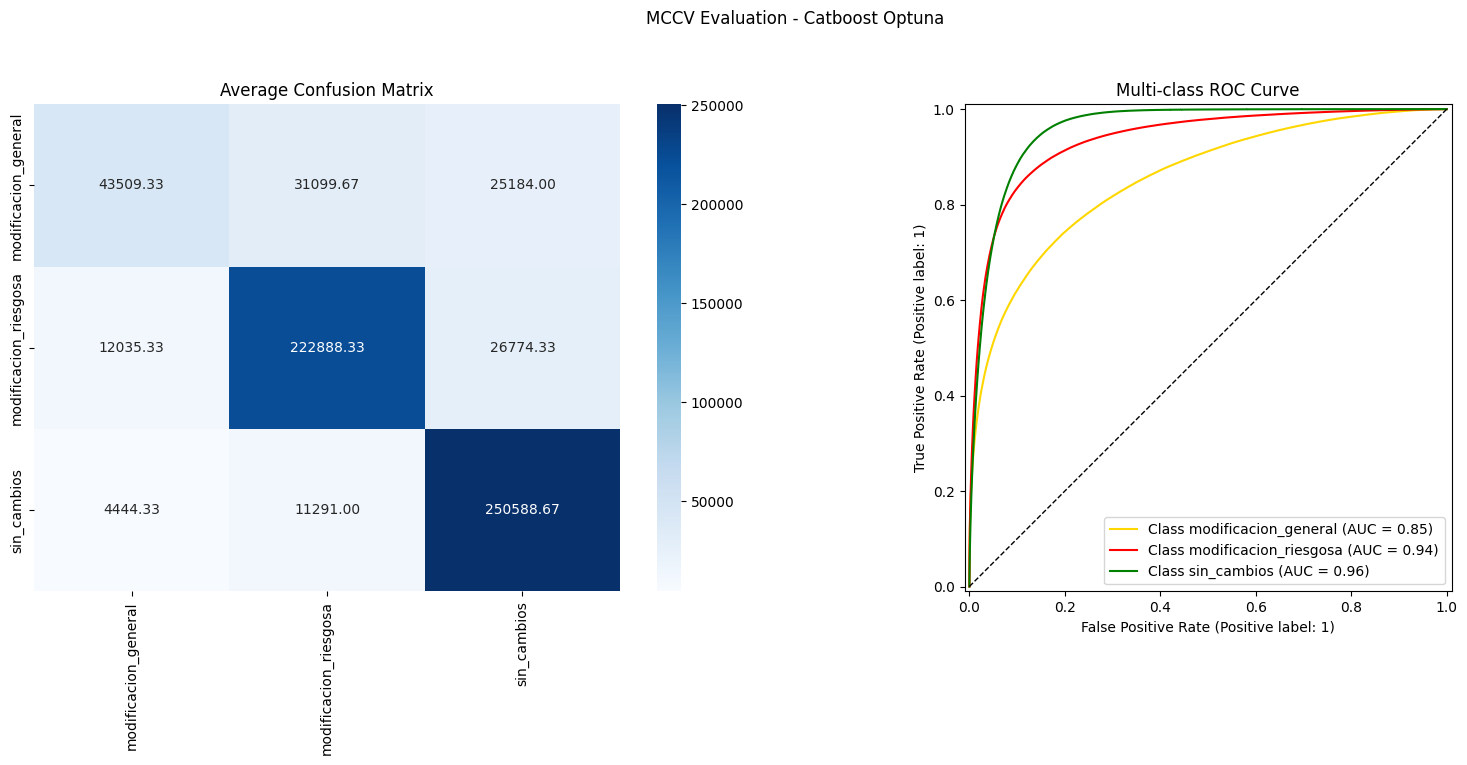

In [12]:
# Final MCCV evaluation
avg_conf_matrix = mccv_evaluation(model, X, y, repeats=3, train_size=0.7, pipeline_name="Catboost Optuna", categorical_features=categorical_features)


In [13]:
sample_idx = np.random.choice(len(X), size=1000, replace=False)
X_sample = X.iloc[sample_idx]
y_sample = y.iloc[sample_idx]
pool = Pool(X_sample, label=y_sample, cat_features=categorical_features)

importance_loss_change = model.get_feature_importance(data=pool, type='LossFunctionChange')
